In [1]:
import itertools
import numpy as np
import pandas as pd

In [2]:
class Pseudorandomizer(object):
    
    def __init__(self, data, max_identical_iters={'cue': 4, 'correct_answer': 4}):  
        self.data = data
        self.max_identical_iters = {x: y+1 for x, y in max_identical_iters.items()}
                                    # add 1: if 4 rows is allowed, only give an error after 5 identical rows
    
    def check_trial_rows(self, data, row_n): 
        """
        Returns True if any of the conditions for pseudorandomization are violated for the given rows, 
        False if they are fine.
        """
        
        # First, check for the maximum iterations
        for column, max_iter in self.max_identical_iters.items():
            if row_n - max_iter < 0:
                continue

            # Select rows [max_iter-1 - row_n] we're going to check. Never select any row with index < 0
            row_selection = [x for x in np.arange(row_n, row_n-max_iter, -1)]

            # Next, we check if the selected rows only contain *1* trial type. 
            # If so, this means we have max_iter rows of the same trials, and we need to change something.
            if data.iloc[row_selection][column].nunique() == 1:
                return True

        return False

    def run(self, debug=False):
        """
        Pseudorandomizes: makes sure that it is not possible to have more than x iterations for every type of column, specified in columns.
        """
        # Start by copying from original data, and shuffle
        self.data = self.data.sample(frac=1, 
                                     random_state=np.random.randint(0, 1e7, dtype='int')).reset_index(drop=True) 
        
        if debug:
            outer_while_i = 0
            debug_print_after_i = 100

        good_set = False
        while not good_set:
            if debug:
                outer_while_i += 1

            reshuffle = False  # Assume the dataset does not need reshuffling.
            for row_n in range(0, self.data.shape[0]):

                # Select rows [max_iter-1 - row_n] we're going to check

                # Check if the current row, and the (max_iters-1) rows before, are the same value (number of unique values = 1).
                # If so, then move the current row number to the bottom of the dataframe. However, we need to re-check the same four rows again
                # after moving a row to the bottom: therefore, a while loop is necessary.
                checked_row = False
                n_attempts_at_moving = 0
                
                if debug:
                    inner_while_i = 0
                
                while not checked_row:
                    if debug:
                        inner_while_i += 1
                        if inner_while_i > debug_print_after_i:
                            print('New inner loop started for current row')

                    if self.check_trial_rows(self.data, row_n):
                        if debug and inner_while_i > debug_print_after_i:
                            print('Found too many consecutively identical rows.')

                        # If there are too many consecutively identical rows at the bottom of the dataframe, 
                        # break and start over/shuffle
                        if row_n >= (self.data.shape[0] - self.max_identical_iters[list(self.max_identical_iters.keys())[0]]):
                            if debug and inner_while_i > debug_print_after_i:
                                print('These occurred at row_n %d, which is at the bottom of the DF.' % row_n)

                            checked_row = True
                            reshuffle = True

                        # Too many consecutive identical rows? Move row_n to the bottom, and check again with the new row_n.
                        else:
                            if debug and inner_while_i > debug_print_after_i:
                                print('These occurred at row_n %d. Checking the remainder of the DF.' % row_n)

                            # Check if moving to the bottom even makes sense: if all remaining values are identical, it doesn't.
                            if (self.data.iloc[row_n:][self.max_identical_iters.keys()].nunique().values < 2).any():
                                if debug and inner_while_i > debug_print_after_i:
                                    print('All remaining values are identical. I should stop the for-loop, and start over.')

                                checked_row = True
                                reshuffle = True
                            else:
                                if n_attempts_at_moving < 50:
                                    n_attempts_at_moving += 1

                                    if debug and inner_while_i > debug_print_after_i:
                                        print('Not all remaining values are identical. I should move the final part to the bottom.')

                                    # If not, move the current row to the bottom
                                    row_to_move = self.data.iloc[row_n,:]

                                    # Delete row from df
                                    self.data.drop(row_n, axis=0, inplace=True)

                                    # Append original row to end. Make sure to reset index
                                    self.data = self.data.append(row_to_move).reset_index(drop=True)

                                # If we already tried moving the current row to the bottom for 50 times, let's forget about it and restart
                                else:
                                    checked_row = True
                                    reshuffle = True
                    else:
                        if debug and inner_while_i > debug_print_after_i:
                            print('Checked row, but the row is fine. Next row.')
                        checked_row = True

                if reshuffle:
                    good_set = False
                    break  # out of the for loop

                # Reached the bottom of the dataframe, but no reshuffle call? Then we're set.
                if row_n == self.data.shape[0]-1:
                    good_set = True

            if reshuffle:
                # Shuffle, reset index to ensure trial_data.drop(row_n) rows
                self.data = self.data.sample(frac=1, random_state=np.random.randint(0, 1e7, dtype='int')).reset_index(drop=True)
        
        return self.data

In [3]:
# pseudoexponential_ps = np.array([8, 4, 2, 1])
# pseudoexponential_ps = pseudoexponential_ps/pseudoexponential_ps.sum()
# phase_settings = [{'phase_name': 'iti_pretrial',
#                    'durations': 0.5 + np.array([0, .75, 1.5, 2.25]),
#                    'probabilities': pseudoexponential_ps},
#                   {'phase_name': 'cue',
#                    'durations': [1.0],
#                    'probabilities': [1]},
#                   {'phase_name': 'fix_cross',
#                    'durations': np.array([1, 1.75, 2.5, 3.25]),
#                    'probabilities': pseudoexponential_ps},
#                   {'phase_name': 'stimulus',
#                    'durations': 1.5 + np.array([0, .5, 1, 1.5]),
#                    'probabilities': pseudoexponential_ps},
#                   {'phase_name': 'highlight',
#                    'durations': .75 + np.array([0, .5, 1, 1.5]),
#                    'probabilities': pseudoexponential_ps},
#                   {'phase_name': 'feedback',
#                    'durations': [1],
#                    'probabilities': [1]}]

In [3]:
# timing parameters
def generate_onsets_fixed_duration(phase_settings,
                                   n_trials=100, trial_duration = 9,
                                   n_null_trials=6, null_trial_duration = 6,
                                   null_trial_min_row=8, 
                                   null_trial_max_row=8, min_n_rows_separate=8):
    # create onsets/durations dataframe
    trial_nr = np.arange(n_trials, dtype=int)
    
    for i in range(100):
        duration_df = pd.DataFrame(index=trial_nr)

        for phase_nr, phase_dict in enumerate(phase_settings):
            duration_df[phase_dict['phase_name']] = np.random.choice(phase_dict['durations'], 
                                                                     p=phase_dict['probabilities'],
                                                                     replace=True, size=n_trials)

        # make sure first trial, pre-trial iti has at least 1 second
        duration_df.iloc[0,0] = np.max([1, duration_df.iloc[0,0]])
        cumulative_durations = duration_df.apply(sum, axis=1)
        post_iti_durations = trial_duration - cumulative_durations

        # find trials where total trial duration is longer than 9 seconds (trial_duration)
        for idx in np.argwhere(cumulative_durations > trial_duration):
            # subtract the overshoot in trial duration from the phase that takes longest
            longest_phase = duration_df.loc[idx, ['fix_cross_1', 'fix_cross_2', 'fix_cross_3', 'fix_cross_4']].apply(np.argmax, axis=1)
            duration_df.loc[idx, longest_phase] += post_iti_durations[idx].values

        # recalc cumulative duration
        cumulative_duration_nopostiti = duration_df.apply(sum, axis=1)
        duration_df['iti_posttrial'] = trial_duration - cumulative_duration_nopostiti

        if n_null_trials > 0:
            # insert 'null trials'
            good_idx = False
            while not good_idx:
                indx = np.random.choice(np.arange(min_n_rows_separate, 
                                                  duration_df.shape[0]-null_trial_max_row), 
                                        replace=False, size=n_null_trials)
                diffs = np.diff(np.sort(indx))
                if (diffs >= min_n_rows_separate).all():
                    good_idx = True
            duration_df.loc[indx, 'iti_posttrial'] += null_trial_duration
        duration_df['cumulative'] = duration_df.apply(sum, axis=1)
        if np.sum(duration_df<0).sum() > 0:
            if i == 99:
                print('WARNING! only negative durations found after 100 attempts')
            else:
                continue
        else:
            break

    # Some reshaping tricks to extract onsets
    onset_df = duration_df.iloc[:,:-1].copy()
    onset_df.index.name = 'trial_nr'
    onset_df = onset_df.reset_index()
    onset_df = onset_df.melt(id_vars=['trial_nr'], value_name='duration', var_name='phase_name')
    
    # make look-up dict
    look_up = {phase_info['phase_name']: phase_nr for phase_nr, phase_info in enumerate(phase_settings)}
    look_up['iti_posttrial'] = len(look_up)
    onset_df['phase_nr'] = onset_df['phase_name'].replace(look_up)
    
    # sort, calculate durations
    onset_df = onset_df.sort_values(by=['trial_nr', 'phase_nr'])
    onset_df['cumulative_duration'] = onset_df['duration'].cumsum()
    onset_df['onset'] = onset_df['cumulative_duration'].shift(1, fill_value=0)
    
    # clean up
    onset_df = onset_df[['trial_nr', 'phase_nr', 'phase_name', 
                         'onset', 'duration', 'cumulative_duration']].reset_index(drop=True)

    return onset_df, duration_df

# onsets, durations = generate_onsets_fixed_duration(phase_settings)

In [4]:
def generate_block_design(n_trials, ps,
                          stimulus_sets=[0,1,2],
                          include_cue=True,
                          pseudorandomize=True,
                          phase_settings=None, 
                          **kwargs):
    """ Generates design for a single block.
    """
    
    correct_stim_lr = [0, 1]
    if include_cue:
        cues = ['SPD', 'ACC']
    else:
        cues = ['']
    combs = list(itertools.product(stimulus_sets, correct_stim_lr, cues))
    
    # make basic df
    design = pd.DataFrame(combs * int(np.ceil((n_trials/len(combs)))), 
                          columns=['stimulus_set', 'correct_stim_lr', 'cue_txt'])
    
    # randomize / shuffle
    design = design.sample(frac=1).reset_index(drop=True)#.reset_index('trial_ID')
    n_trials_real = design.shape[0]
    design = design.iloc[:n_trials]
    
    if not n_trials == n_trials_real:
        print('WARNING: not totally balanced (%d not a multitude of %d)' %(n_trials, len(combs)))
    
    if pseudorandomize:
        design = Pseudorandomizer(design, max_identical_iters={'stimulus_set': 2,
                                                               'cue_txt': 4}).run()
    
    # Add probabilities (left/right and correct/incorrect - this is redundant, I know)
    design['p_win_left'] = None
    design['p_win_right'] = None
    design['p_win_correct'] = None
    design['p_win_incorrect'] = None
    for stimulus_set, p_win in zip(stimulus_sets, ps):
        p_win_high, p_win_low = p_win[0], p_win[1]
        design.loc[(design.stimulus_set==stimulus_set) & (design.correct_stim_lr == 0), 'p_win_left'] = p_win_high
        design.loc[(design.stimulus_set==stimulus_set) & (design.correct_stim_lr == 1), 'p_win_right'] = p_win_high
        design.loc[(design.stimulus_set==stimulus_set) & (design.correct_stim_lr == 1), 'p_win_left'] = p_win_low
        design.loc[(design.stimulus_set==stimulus_set) & (design.correct_stim_lr == 0), 'p_win_right'] = p_win_low
        design.loc[(design.stimulus_set==stimulus_set), 'p_win_correct'] = p_win_high
        design.loc[(design.stimulus_set==stimulus_set), 'p_win_incorrect'] = p_win_low
    
    design['trial_nr'] = np.arange(design.shape[0], dtype='int')
    
    if phase_settings is not None:
#         onsets_long, _ = generate_onsets_fixed_duration(phase_settings=phase_settings, n_trials=n_trials)
#         onsets_wide = pd.pivot_table(onsets_long, values='onset', index='trial_nr', columns='phase_name').reset_index()
        onsets, durations = generate_onsets_fixed_duration(phase_settings=phase_settings, n_trials=n_trials, **kwargs)
        durations['trial_nr'] = np.arange(durations.shape[0], dtype='int')
        durations = durations.rename(columns={'cumulative': 'total_duration'})
        design = pd.merge(design, durations, on='trial_nr')
        
        # make sure to generate the onsets long file
        acc_trials = design.loc[design['cue_txt'] == 'ACC', 'trial_nr']
        spd_trials = design.loc[design['cue_txt'] == 'SPD', 'trial_nr']
        
        onsets.loc[(np.in1d(onsets['trial_nr'], acc_trials) & (onsets.phase_name == 'cue')), 'phase_name'] = 'cue_acc'
        onsets.loc[(np.in1d(onsets['trial_nr'], spd_trials) & (onsets.phase_name == 'cue')), 'phase_name'] = 'cue_spd'
        
        # clean up
        design = design[['trial_nr', 'stimulus_set', 'correct_stim_lr', 'cue_txt', 'p_win_left', 'p_win_right', 'p_win_correct', 'p_win_incorrect',
                         'fix_cross_1', 'cue', 'fix_cross_2', 'stimulus', 'fix_cross_3', 
                         'highlight', 'fix_cross_4', 'feedback', 'iti_posttrial', 'total_duration']]
        return design, onsets
    
    return design

# design, onsets = generate_block_design(n_trials=96, 
#                                        stimulus_sets=[0, 1, 2], 
#                                        ps=[[0.8, 0.2], [0.7, 0.3], [0.6, 0.4]],
#                                        phase_settings=phase_settings)

In [5]:
def counterbalance_stimuli(subject_id, all_stimuli=None,
                           reverse_pairs=(False, True),
                           shifts_within_blocks=(0,1,2),
                           shifts_across_blocks=(0,1,2),
                           verbose=True):
    """ reverse_pairs = switch first and second half of the sets (useful for different block types) 
    
    """
    import itertools
    from copy import deepcopy
    
    if all_stimuli is None:
        print('WARNING: default stimuli sets used')
        all_stimuli = [[[1, 2], [3, 4], [5, 6]],       # block 1
                       [[7, 8], [9, 10], [11, 12]],    # block 2
                       [[13, 14], [15,16], [17, 18]]]  # block 3

#     options
#     reverse_pair = [False, True]
#     shifts_within_blocks = [0, 1, 2]
#     shifts_across_blocks = [0, 1, 2]

    cb_df = pd.DataFrame(list(itertools.product(shifts_across_blocks,
                                                shifts_within_blocks, 
                                                reverse_pairs)),
                         columns=['shifts_across_blocks', 'shifts_within_blocks', 'reverse_pairs'])
    n_unique_permutations = cb_df.shape[0]

    pp_zero_based = int(subject_id) - 1
    row_iloc = int(pp_zero_based - np.floor(pp_zero_based / n_unique_permutations) * n_unique_permutations)

    settings = cb_df.iloc[row_iloc]
    stimuli_this_sub = deepcopy(all_stimuli)

    # shift blocks
    for i in range(settings.shifts_across_blocks):
        stimuli_this_sub.insert(len(stimuli_this_sub), stimuli_this_sub.pop(0))

    # loop over stimuli per block
    for block_n in range(len(stimuli_this_sub)):

        # reverse pair order
        for stimulus_set in stimuli_this_sub[block_n]:
            if settings.reverse_pairs:
                stimuli_this_sub[block_n] = [x[::-1] for x in stimuli_this_sub[block_n]]  # reverse inner order

        # shift pairs within block
        for i in range(settings.shifts_within_blocks):
            stimuli_this_sub[block_n].insert(len(stimuli_this_sub[block_n]), stimuli_this_sub[block_n].pop(0))

    if verbose:
        print('Stimuli this subject: {}'.format(stimuli_this_sub))
    return stimuli_this_sub

In [6]:
def get_stimuli(subject_id, design, stimulus_sets):
    
    all_stim = counterbalance_stimuli(subject_id, 
                                      all_stimuli=stimulus_sets)
    # flatten
    all_stim = [item for sublist in all_stim for item in sublist]
    
    design['stim_left'] = None
    design['stim_right'] = None
    design['stim_high'] = None
    design['stim_low'] = None

    
    for i in range(len(all_stim)):
        idx_this_stim = design.stimulus_set == i
        design.loc[idx_this_stim, 'stim_high'] = all_stim[i][0]
        design.loc[idx_this_stim, 'stim_low'] = all_stim[i][1]

    for i in range(len(all_stim)):
        idx_this_stim = design.stimulus_set == i
        idx_this_stim_nonrev = (idx_this_stim) & (design.correct_stim_lr == 0)
        idx_this_stim_rev = (idx_this_stim) & (design.correct_stim_lr == 1)

        design.loc[idx_this_stim_nonrev, 'stim_left'] = design.loc[idx_this_stim_nonrev, 'stim_high']
        design.loc[idx_this_stim_nonrev, 'stim_right'] = design.loc[idx_this_stim_nonrev, 'stim_low']
        design.loc[idx_this_stim_rev, 'stim_left'] = design.loc[idx_this_stim_rev, 'stim_low']
        design.loc[idx_this_stim_rev, 'stim_right'] = design.loc[idx_this_stim_rev, 'stim_high']
   
    return design

In [7]:
all_stimulus_sets = [[['C', 'c'],     #Cc
                      ['D', 'g'],     #Dg
                      ['f', 'x']],    #fx
                     [['j', 'N'],     #jN
                      ['Q', 'J'],     #QJ
                      ['m', 'M']],    #mM
                     [['R', 'S'],     #RS
                      ['s', 'T'],     #sT
                      ['t', 'U']]]    #tU
n_runs = 3
subject_id = 1

In [8]:
# pseudoexponential_ps = np.array([8, 4, 2, 1])
# pseudoexponential_ps = pseudoexponential_ps/pseudoexponential_ps.sum()
# phase_settings = [{'phase_name': 'fix_cross_1',
#                    'durations': 0.5 + np.array([0, .5, 1, 1.5]),
#                    'probabilities': pseudoexponential_ps},
#                   {'phase_name': 'cue',
#                    'durations': [1.0],
#                    'probabilities': [1]},
#                   {'phase_name': 'fix_cross_2',
#                    'durations': 1 + np.array([0, .5, 1, 2]),
# #                   'durations': 1 + np.array([0, .5, 1, 1.5]),
#                    'probabilities': pseudoexponential_ps},
#                   {'phase_name': 'stimulus',
#                    'durations': [1.5],
#                    'probabilities': [1]},
#                   {'phase_name': 'fix_cross_3',
#                    'durations': 0 + np.array([0, 1, 1.5, 2]),
#                    'probabilities': pseudoexponential_ps},
#                   {'phase_name': 'highlight',
#                    'durations': [1],
#                    'probabilities': [1]},
#                   {'phase_name': 'fix_cross_4',
#                    'durations': 0 + np.array([0, 1, 1.5, 2]),
#                    'probabilities': pseudoexponential_ps},
#                   {'phase_name': 'feedback',
#                    'durations': [1],
#                    'probabilities': [1]}]

pseudoexponential_ps = np.array([8, 4, 2, 1])
pseudoexponential_ps = pseudoexponential_ps/pseudoexponential_ps.sum()
pseudoexponential_ps_3 = np.array([4, 2, 1])
pseudoexponential_ps_3 = pseudoexponential_ps_3/pseudoexponential_ps_3.sum()

phase_settings = [{'phase_name': 'fix_cross_1',
                   'durations': 0.5 + np.array([0, .5, 1]),
                   'probabilities': pseudoexponential_ps_3},
                  {'phase_name': 'cue',
                   'durations': [1.0],
                   'probabilities': [1]},
                  {'phase_name': 'fix_cross_2',
                   'durations': 0.5 + np.array([0, .5, 1, 1.5]),
#                   'durations': 1 + np.array([0, .5, 1, 1.5]),
                   'probabilities': pseudoexponential_ps},
                  {'phase_name': 'stimulus',
                   'durations': [1.5],
                   'probabilities': [1]},
                  {'phase_name': 'fix_cross_3',
                   'durations': 0 + np.array([0, 1, 1.5]),
                   'probabilities': pseudoexponential_ps_3},
                  {'phase_name': 'highlight',
                   'durations': [1],
                   'probabilities': [1]},
                  {'phase_name': 'fix_cross_4',
                   'durations': 0 + np.array([0, 1, 1.5, 1.5]),
                   'probabilities': pseudoexponential_ps},
                  {'phase_name': 'feedback',
                   'durations': [1],
                   'probabilities': [1]}]


In [20]:
# WARNING: SETTINGS FOR BEHAVIORAL PILOT
n_null_trials = 0
n_trials = 108
trial_duration = 7.5

for subject_id in np.arange(1, 41, dtype=int):
    designs_this_session = []
    for run in range(1,n_runs+1):
        s0_this_block = (run-1)*3
        stimulus_sets = [s0_this_block, s0_this_block+1, s0_this_block+2]
        design, onsets = generate_block_design(n_trials = n_trials, 
                                               ps=[[0.8, 0.2], [0.7, 0.3], [0.6, 0.4]],
                                               stimulus_sets=stimulus_sets,  # dont touch this
                                               phase_settings=phase_settings,
                                               trial_duration=trial_duration,
                                               n_null_trials=n_null_trials)
        design['block'] = run
        designs_this_session.append(design)

    design = pd.concat(designs_this_session)
    design = get_stimuli(subject_id=subject_id, design=design, stimulus_sets=all_stimulus_sets)

    ###
    subject_id_str = str(subject_id).zfill(2)
    design.to_csv('../designs/sub-' + subject_id_str + '_design.csv', sep='\t')

Stimuli this subject: [[['C', 'c'], ['D', 'g'], ['f', 'x']], [['j', 'N'], ['Q', 'J'], ['m', 'M']], [['R', 'S'], ['s', 'T'], ['t', 'U']]]
Stimuli this subject: [[['c', 'C'], ['g', 'D'], ['x', 'f']], [['N', 'j'], ['J', 'Q'], ['M', 'm']], [['S', 'R'], ['T', 's'], ['U', 't']]]
Stimuli this subject: [[['D', 'g'], ['f', 'x'], ['C', 'c']], [['Q', 'J'], ['m', 'M'], ['j', 'N']], [['s', 'T'], ['t', 'U'], ['R', 'S']]]
Stimuli this subject: [[['g', 'D'], ['x', 'f'], ['c', 'C']], [['J', 'Q'], ['M', 'm'], ['N', 'j']], [['T', 's'], ['U', 't'], ['S', 'R']]]
Stimuli this subject: [[['f', 'x'], ['C', 'c'], ['D', 'g']], [['m', 'M'], ['j', 'N'], ['Q', 'J']], [['t', 'U'], ['R', 'S'], ['s', 'T']]]
Stimuli this subject: [[['x', 'f'], ['c', 'C'], ['g', 'D']], [['M', 'm'], ['N', 'j'], ['J', 'Q']], [['U', 't'], ['S', 'R'], ['T', 's']]]
Stimuli this subject: [[['j', 'N'], ['Q', 'J'], ['m', 'M']], [['R', 'S'], ['s', 'T'], ['t', 'U']], [['C', 'c'], ['D', 'g'], ['f', 'x']]]
Stimuli this subject: [[['N', 'j'], ['J',

In [11]:
tmp = design[['fix_cross_1', 'cue', 'fix_cross_2', 'stimulus', 'fix_cross_3', 'highlight', 'fix_cross_4', 'feedback', 'iti_posttrial']]
tmp.head()

,fix_cross_1,cue,fix_cross_2,stimulus,fix_cross_3,highlight,fix_cross_4,feedback,iti_posttrial
0,1.0,1.0,1.0,1.5,1.0,1,0.0,1,1.5
1,0.5,1.0,1.0,1.5,1.0,1,2.0,1,0.0
2,0.5,1.0,1.0,1.5,1.5,1,1.5,1,0.0
3,0.5,1.0,1.0,1.5,0.0,1,1.0,1,2.0
4,0.5,1.0,1.5,1.5,1.5,1,1.0,1,0.0


## Compare real timing with expected timing

In [15]:
design = pd.read_csv('../designs/sub-02_design.csv', sep='\t')
# design

In [16]:
def design_to_onsets(design, phase_settings):
#     design.index.name = 'trial_nr'
#     design = design.reset_index()

#     phase_names = [x['phase_name'] for x in phase_settings]
#     phase_names.append('iti_posttrial')

    onset_df = design.copy()
    onset_df = onset_df.melt(id_vars=['trial_nr'], 
                             value_name='duration', 
                             var_name='phase_name')
    
    look_up = {phase_info['phase_name']: phase_nr for phase_nr, phase_info in enumerate(phase_settings)}
    look_up['iti_posttrial'] = len(look_up)
    onset_df['phase_nr'] = onset_df['phase_name'].replace(look_up)
    
    # sort, calculate durations
    onset_df = onset_df.sort_values(by=['trial_nr', 'phase_nr'])
    onset_df['cumulative_duration'] = onset_df['duration'].cumsum()
    onset_df['onset'] = onset_df['cumulative_duration'].shift(1, fill_value=0)
    
    # clean up
    onset_df = onset_df[['trial_nr', 'phase_nr', 'phase_name', 
                         'onset', 'duration', 'cumulative_duration']].reset_index(drop=True)
    
    return onset_df

block_idx = design.block == 1
cols = ['trial_nr', 'fix_cross_1', 'cue', 'fix_cross_2', 'stimulus', 'fix_cross_3', 'highlight', 'fix_cross_4', 'feedback', 'iti_posttrial']

preset_onsets = design_to_onsets(design.loc[block_idx, cols], 
                                 phase_settings=phase_settings)
preset_onsets = preset_onsets.rename(columns = {'phase_name': 'event_type'})
preset_onsets['event_type'] = preset_onsets['event_type'].replace({'iti_posttrial': 'fix_cross_5'})

In [1]:
import os
import pandas as pd

In [11]:
path = '/Users/steven/surfdrive/data/learningTask/pilot_prefmri/'
fn = 'sub-1_task-learning_datetime-20191104-131156_events.tsv'
measured = pd.read_csv(os.path.join(path, fn), sep='\t')
measured_onsets = measured.loc[pd.notnull(measured['duration']) & (measured['trial_nr'] >= 0.), ['trial_nr', 'onset', 'event_type', 'duration']]

In [6]:
merged = pd.merge(preset_onsets, measured_onsets, on=['trial_nr', 'event_type'], suffixes=('_preset', '_measured'))
merged['onset_measured_reset'] = merged['onset_measured'] - merged.iloc[0]['onset_measured']
merged['difference'] = merged['onset_measured_reset'] - merged['onset_preset']

NameError: name 'preset_onsets' is not defined

In [4]:
merged

NameError: name 'merged' is not defined

## check out frame intervals

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
dat = np.loadtxt(os.path.join(path, fn.replace("_events.tsv", "_frameintervals.log")), delimiter=',')
# dat = np.loadtxt('/Volumes/SteefSSD/IMCN-learningtask/IMCN-learningtask/data/sub-1_task-learning_datetime-20191016-131043_frameintervals.log', delimiter=',')

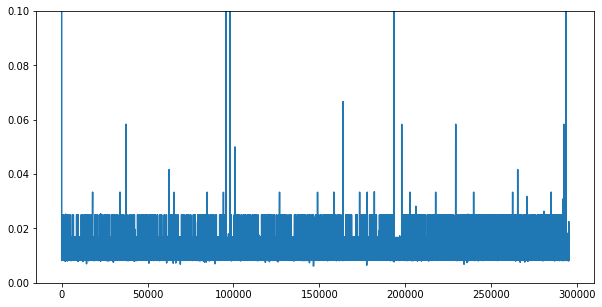

In [9]:
f, ax = plt.subplots()
ax.plot(dat)

ax.set_ylim(0, 0.1)
plt.gcf().set_size_inches(10, 5)

In [29]:
# data = pd.read_csv('/Volumes/SteefSSD/IMCN-learningtask/IMCN-learningtask/data/sub-1_task-learning_datetime-20191016-131043_events.tsv', sep='\t')

### Are the reward probabilities as expected?

In [53]:
# measured

In [12]:
#path = '/Users/steven/Sync/PhDprojects/IMCN-learningtask/IMCN-learningtask/data'
#fn = 'sub-2_task-learning_datetime-20191101-121137_events.tsv'
measured = pd.read_csv(os.path.join(path, fn), sep='\t')
data = measured.loc[(measured['event_type']=='response') & (measured['phase'] == 3)]
data.groupby('response')['choice_outcome'].mean()

response
m    0.644295
z    0.626437
Name: choice_outcome, dtype: float64

In [14]:
data['choice_symbol'] = np.nan
data.loc[data.response == 'm', 'choice_symbol'] = data.loc[data.response == 'm', 'stimulus_symbol_right']
data.loc[data.response == 'z', 'choice_symbol'] = data.loc[data.response == 'z', 'stimulus_symbol_left']

data['p_choice'] = np.nan
data.loc[data['response'] == 'm', 'p_choice'] = data.loc[data.response == 'm', 'p_win_right']
data.loc[data['response'] == 'z', 'p_choice'] = data.loc[data.response == 'z', 'p_win_left']

#data.choice_symbol.value_counts()
data.groupby('choice_symbol')['choice_outcome'].mean()

#data.groupby('p_choice')['choice_outcome'].sum()

/Users/steven/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/steven/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


choice_symbol
C    0.800000
D    0.705882
J    0.142857
M    0.400000
N    0.333333
Q    0.655172
R    0.800000
S    1.000000
T    0.142857
U    0.400000
c    0.000000
f    0.500000
g    0.000000
j    0.818182
m    0.580645
s    0.620690
t    0.653846
x    0.300000
Name: choice_outcome, dtype: float64

In [16]:
# data.groupby('choice_symbol')['choice_outcome'].mean()

In [17]:
data.groupby('stimulus_symbol_left')['p_win_left'].unique()

stimulus_symbol_left
C    [0.8]
D    [0.7]
J    [0.3]
M    [0.4]
N    [0.2]
Q    [0.7]
R    [0.8]
S    [0.2]
T    [0.3]
U    [0.4]
c    [0.2]
f    [0.6]
g    [0.3]
j    [0.8]
m    [0.6]
s    [0.7]
t    [0.6]
x    [0.4]
Name: p_win_left, dtype: object

In [23]:
data

,trial_nr,onset,event_type,phase,response,nr_frames,stimulus_symbol_left,stimulus_symbol_right,correct_response,block_nr,...,rt,rt_too_slow,rt_too_fast,rt_in_time,choice_key,choice_direction,choice_outcome,total_points_earned,onset_abs,duration
0,0.0,1.126478,fix_cross_1,0.0,NaN,22.0,B,A,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.501072,0.992898
1,0.0,2.119376,cue,1.0,NaN,22.0,B,A,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.493970,1.000099
2,0.0,3.000418,pulse,1.0,t,NaN,B,A,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.375012,NaN
3,0.0,3.119475,fix_cross_2,2.0,NaN,21.0,B,A,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.494069,1.000000
4,0.0,4.119475,stimulus,3.0,NaN,30.0,B,A,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.494069,1.507035
5,0.0,4.562867,response,3.0,m,NaN,B,A,1.0,1.0,...,0.443392,False,False,True,m,1.0,1.0,100.0,5.937461,NaN
6,0.0,5.626510,fix_cross_3,4.0,NaN,0.0,B,A,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.001104,0.008921
7,0.0,5.635431,highlight,5.0,NaN,20.0,B,A,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.010025,1.002742
8,0.0,6.002402,pulse,5.0,t,NaN,B,A,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.376996,NaN
9,0.0,6.638173,fix_cross_4,6.0,NaN,0.0,B,A,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.012767,0.008395
